# Ferromagnetic 2D square lattice XY model using NumPy and Numba

## Import the required libraries.

In [1]:
import numpy as np
from Metropolis_functions import Metropolis_slow_quench
from Observables import get_specificheat, get_squared_magnetisation
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [49]:
def get_clusters(array):
    addresses_clusters = []
    for i in range(1, np.max(array)+1):
        addresses_clusters.append(np.transpose(np.where(array == i)))
    return addresses_clusters


def index_format(direction):
    return np.split(direction, 2)


def get_random_cluster_element(addresses):
    length = len(addresses)
    return addresses[np.random.choice(range(length))]


def get_random_neighbor(array=[[0, 1], [0, -1], [1, 0], [-1, 0]]):
    return np.array(array[np.random.choice(range(len(array)))])


def propagate(array, boolean_array, center, direction):

    initial = index_format(center)
    final = index_format((center+direction) % len(array))

    if boolean_array[final] and boolean_array[initial]:
        if not array[initial][0] == array[final][0]:
            array[np.where(array == array[final])] = array[initial]
            boolean_array[initial] = False
            boolean_array[final] = False
            #array = relabel_clusters(array)
    return array, boolean_array


def propagate_xy(array, boolean_array, spins, random_vector, center, direction, temperature):

    initial = index_format(center)
    final = index_format((center+direction) % len(array))
    # check array not used before
    if boolean_array[final] and boolean_array[initial]:
        # check not previously part of the same cluster
        if not array[initial][0] == array[final][0]:
            # check spin dependent conditions
            if spins_aligned(element=center,
                             direction=direction,
                             spins=spins,
                             random_vector=random_vector):
                if temp_prob(temperature) > np.random.rand():
                    print(temp_prob(temperature))
                    # add to cluster
                    array[np.where(array == array[final])] = array[initial]
                    # update boolean array
                    boolean_array[initial] = False
                    boolean_array[final] = False
    return array, boolean_array


def temp_prob(temperature, J=1):
    return 1 - np.exp(-J/np.abs(temperature))


def propagation_round_xy(array, spins, random_vector, temperature):
    print('propagation round...')

    boolean_array = array < np.max(array)+1
    cluster_addresses = get_clusters(array)
    random_elements = [get_random_cluster_element(cluster_addresses[i]) for i in range(len(cluster_addresses))]

    for element in random_elements:
        direction = get_random_neighbor()

        array, boolean_array = propagate_xy(array=array,
                                         boolean_array=boolean_array,
                                         center=element,
                                         direction=direction,
                                           spins=spins,
                                           random_vector=random_vector,
                                           temperature=temperature)

    array = relabel_clusters(array)

    return array


def spins_aligned(element, direction, spins, random_vector):

    initial = index_format(element)
    final = index_format((element+direction) % len(spins))
    #print(get_vector_components(spins[initial]).flatt)
    #print(random_vector)

    proj1 = np.dot(get_vector_components(spins[initial]).flatten(), random_vector)
    proj2 = np.dot(get_vector_components(spins[final]).flatten(), random_vector)
    

    if proj1*proj2 > 0:
        return True
    else:
        return False


def propagation_round(array, p):
    print('propagation round...')
    boolean_array = array < np.max(array)+1
    cluster_addresses = get_clusters(array)
    random_elements = [get_random_cluster_element(cluster_addresses[i]) for i in range(len(cluster_addresses))]

    for element in random_elements:
        direction = get_random_neighbor()

        if np.random.rand() < p:
            array, boolean_array = propagate(array=array,
                                             boolean_array=boolean_array,
                                             center=element,
                                             direction=direction)
    array = relabel_clusters(array)

    return array



def get_vector_components(angle):
    return np.array([np.cos(angle), np.sin(angle)])


def percolation(invaded):

    L = len(invaded)
    ones_vec = np.ones(L)
    ones_cluster = np.zeros((L, L))
    ones_cluster[np.where(invaded == np.max(invaded))] = 1
    path_1 = ones_cluster.dot(ones_vec)
    path_2 = ones_cluster.T.dot(ones_vec)

    if 0. not in path_1 or 0. not in path_2:
        percolation = True
    else:
        percolation = False

    return percolation


def relabel_clusters(array):
    aux = np.copy(array)
    bins = np.bincount(aux.flatten())
    dat = np.nonzero(bins)[0]
    i = 1
    sorted_dat = np.array(sorted(zip(bins[bins != 0], dat)))

    for element in sorted_dat:
        if element[0] != 0:
            array[np.where(aux == element[1])] = i
            i += 1
    return array

In [50]:
def xy_model(L, n_steps=1):

    spins = 2*np.pi*np.random.rand(L, L)
    invaded = np.resize(np.arange(1, L*L), (L, L))
    temperature = 1E-10
    ts = []
    ims = []
    n = 0
    perc = False
    while n < n_steps:

        while not perc:

            random_vector = get_vector_components(2*np.pi*np.random.rand())
            invaded = propagation_round_xy(invaded, spins, random_vector, temperature)
            perc = percolation(invaded)

        spins = rotate_percolated_cluster(spins, invaded, random_vector)
        im = plt.imshow(spins, animated=True)
        ims.append([im])
        ts.append(temperature)
        temperature = get_temperature(spins)
        n += 1

    return spins, invaded, ts, ims


def rotate_percolated_cluster(spins, invaded, random_vector):
    random_angle = np.arctan(random_vector[1]/random_vector[0])
    for i in range(np.max(invaded.flatten())):
        if np.random.rand() < 1/2:
            spins[np.where(invaded == i+1)] += random_angle
    spins = spins % (2*np.pi)
    return spins


def get_energy_per_spin_per_lattice(J, lattice):
	"""
	Calculates and returns the energy sum over the lattice.

	Parameters
	----------
		J: float
			Coupling constant. It must follow that J>0 such that we are studying the ferromagnetic XY-model.
		
		lattice: np.ndarray (float)
			The input lattice containing L×L spins.

	Returns
	-------
		E: np.ndarray (float)
			Energy of each spin in the lattice.
	"""
	E = -J * (np.cos(lattice - np.roll(lattice, 1, axis=0)) +
				np.cos(lattice - np.roll(lattice, -1, axis=0)) +
				np.cos(lattice - np.roll(lattice, 1, axis=1)) +
				np.cos(lattice - np.roll(lattice, -1, axis=1)))
	return E


def get_temperature(spins):
    return -(2/3)*np.sum(np.sum(get_energy_per_spin_per_lattice(J=1, lattice=spins)))

def percolation_model(L, p):
    invaded = np.resize(np.arange(1, L*L), (L,L))
    ims = [[plt.imshow(invaded, animated=True)]]
    step = 1
    perc = False
    while not perc:
        invaded = propagation_round(invaded, p)
        im = plt.imshow(invaded, animated=True)
        ims.append([im])
        perc = percolation(invaded)
        # print(percolation(invaded), invaded)
    return ims, invaded

propagation round...


<ipython-input-49-5664941167ff>:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if boolean_array[final] and boolean_array[initial]:
<ipython-input-49-5664941167ff>:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if not array[initial][0] == array[final][0]:
<ipython-input-49-5664941167ff>:92: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


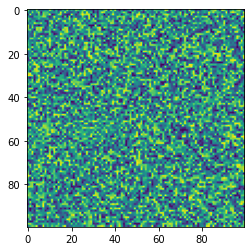

In [51]:
fig = plt.figure()
spins, invaded, ts, ims = xy_model(L=100, n_steps=400)

In [37]:
%matplotlib inline
from IPython.display import HTML
ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat_delay=1)
plt.show()

In [38]:
ts

[1e-10,
 154.16301352180392,
 145.585981858421,
 151.30610860988526,
 162.34057777568776,
 167.60532883290733,
 174.7354725093357,
 196.31021807923997,
 204.62160636320885,
 203.36796917606966,
 211.9413180108948,
 232.2195302369526,
 212.33700763141138,
 207.89471628030697,
 198.33159716563196,
 197.87674292385057,
 184.845069896575,
 197.765307913965,
 203.60342016657756,
 222.22633161486175,
 200.1108811019987,
 201.016817348901,
 214.1472364586736,
 209.29571939245113,
 201.60429253684484,
 221.83998143642776,
 225.8221645301568,
 230.93093064441211,
 241.24655237670441,
 251.99759433618783,
 271.9212352192466,
 257.7773695999939,
 236.14224224287457,
 233.93094123538714,
 220.65885558442437,
 243.98872028486585,
 247.7692700484514,
 236.37429109818845,
 250.39778608120332,
 252.44524738757536,
 231.89923840992904,
 262.3332478273597,
 262.043708923409,
 277.73004115917047,
 286.56334821307087,
 274.46535811767717,
 310.4510465816285,
 314.64267238984655,
 334.13927139461055,
 324.

In [19]:
HTML(ani.to_html5_video())

<ipython-input-764-5236c7fc9fdc>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if boolean_array[final] and boolean_array[initial]:
<ipython-input-764-5236c7fc9fdc>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if not array[initial][0] == array[final][0]:
<ipython-input-764-5236c7fc9fdc>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

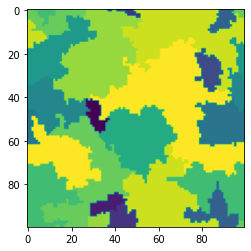

In [766]:
fig = plt.figure()
ims, final_inv = percolation_model(L=100, p=0.2)

In [808]:
%matplotlib inline
from IPython.display import HTML
ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat_delay=1)
plt.show()

In [809]:
HTML(ani.to_html5_video())

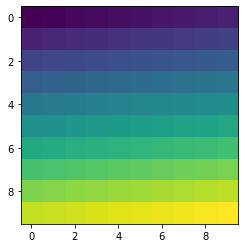

In [205]:
L = 10
plt.imshow(inv_c2)

In [343]:
inv_c2 = np.resize(np.arange(0, L**2), (L, L))
inc_c2 = propagate(inv_c2)

TypeError: propagate() missing 3 required positional arguments: 'boolean_array', 'center', and 'direction'

In [351]:
bins = np.bincount(final_inv.flatten())
data = np.nonzero(bins)[0]

In [353]:
np.column_stack((bins,data))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 3

In [157]:
bins = np.bincount(inv_c2.flatten())
dat = np.nonzero(bins)[0]

In [158]:
positions = np.where(inv_c2 == largest_id)

In [99]:
largest_id = dat[np.where(bins == np.max(bins))][0]-1

In [107]:
L = len(inv_c2)

In [797]:
np.fromfunction(get_vector_components, (3, 3), args=np.random.rand())

TypeError: get_vector_components() got an unexpected keyword argument 'args'

In [161]:
positions

(array([ 9,  9, 10]), array([3, 4, 3]))

In [135]:
path = np.zeros(L, L)
path = 

array([ 2,  2,  2, 12, 12,  7, 12, 10, 12, 14])

In [138]:
borders = np.ones((L,L))

In [160]:
borders[positions] = 0

IndexError: index 10 is out of bounds for axis 0 with size 10

In [145]:
borders

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

<ipython-input-71-185c7e014299>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if boolean_array[final] and boolean_array[initial]:
<ipython-input-71-185c7e014299>:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if not array[initial][0] == array[final][0]:
<ipython-input-71-185c7e014299>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

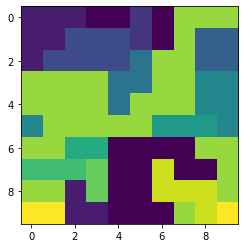

In [79]:
inv_c2 = propagation_round(inv_c2)
plt.imshow(inv_c2)

In [95]:
def flip_spin(T):
    pass

def get_projection():
    pass


def get_neighbor(inv_c, cluster_element, index, T):

    if get_projection(cluster_elementm, index) > 0 and flip_spin(T):
        return index
    else:
        return None


def propagate(inv_c, cluster_element):

    aux = np.rand.random(size=4)
    index = np.where(aux == np.max(aux))
    neighbor = get_neighbor(index)
    if neighbor is not None:
        inv_c[neighbor] = inv_c[cluster_element]
    return inv_c


def propagation_step(cluster, inv_c):

    for cluster_element in cluster:
        inv_c = propagate(inv_c, cluster_element)

    return cluster


def get_cluster_indices():
    pass

def propagate_cluster(inv_c, neighbor, cluster_element, condition)
    if condition:
        inv_c[neighbor] = inv_c[cluster_element]
    

SyntaxError: invalid syntax (<ipython-input-95-9de809354db5>, line 37)

## Initialise the required variables

In [6]:
J = 1 # coupling constant, where it must be > 0 for the system to exhibit ferromagnetism
L = 100 # dimension of the square lattice

tau = 500000 # relaxation time a.k.a equilibrating time
nrelax = 25 # total number of times to let the system equilibrate
nframes = 1 # total number of frames in the .gif over the whole simulation (not needed since we are not generating the animated .gif in this notebook)
N = nrelax * tau # total number of iterations in the Metropolis algorithm
plot_at_Nth_index = np.array([0],dtype=np.int32) # (not needed since we are not generating the animated .gif in this notebook)

lattice = np.zeros((L, L))

Tc = 0.892937 * J  # http://www.lps.ens.fr/~krauth/images/7/72/Stage_Mayer_Johannes_2015.pdf in units of kB
T_init = 0.5
T_final = 2*Tc
TTc_array = np.linspace(T_init, T_final, nrelax)

## Begin the Metropolis time-marching on the lattice

In [7]:
lattices_relax, _, _ = Metropolis_slow_quench(
    J=J,
    L=L,
    relaxation_time=tau,
    plot_at_Nth_index=plot_at_Nth_index,
    lattice=lattice,
    T_init=T_init,
    T_final=T_final,
    T_n=nrelax)

## Calculate the physical observables with the simulation results obtained in the previous cell

## Squared magnetisation

Its expression is given as $\frac{\left\langle M^2\right\rangle}{N^2}=\frac{1}{N^2}\left\langle\left(\sum_{i=1}^{N} \cos \theta_{i}\right)^{2}+\left(\sum_{i=1}^{N} \sin \theta_{i}\right)^{2}\right\rangle$ where $N=L\times L$.

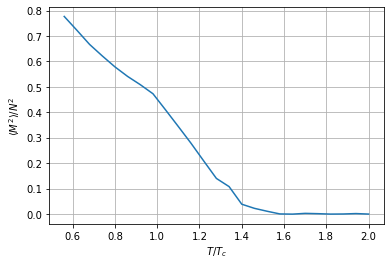

In [8]:
ave_M = get_squared_magnetisation(L,nrelax,lattices_relax)

plt.close()
plt.plot(TTc_array/Tc,ave_M)
plt.xlabel("$T/T_c$")
plt.ylabel("$\langle M^2\\rangle/N^2$")
plt.grid()
plt.show()

## Specific heat

Its expression is given as $c / k_{\mathrm{B}}=\frac{\left\langle E^{2}\right\rangle-{\langle E\rangle}^{2}}{\left(k_{\mathrm{B}} T\right)^{2}}$ where $k_B$ is the Boltzmann's constant.

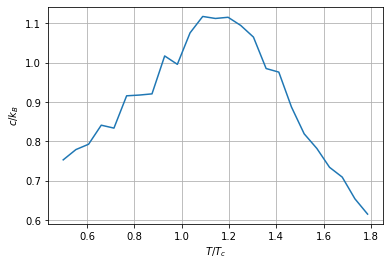

In [9]:
c = get_specificheat(J, nrelax, lattices_relax, TTc_array)

plt.close()
plt.plot(TTc_array,c)
plt.xlabel("$T/T_c$")
plt.ylabel("$c/k_B$")
plt.grid()
plt.show()